In [22]:
import numpy as np
import os
import pandas as pd
np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

%pylab inline
%config InlineBackend.figure_formats = ['retina']

from collections import OrderedDict

import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score

import warnings
warnings.simplefilter(action='ignore')

import imblearn.over_sampling

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer, OneHotEncoder, StandardScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer

Populating the interactive namespace from numpy and matplotlib


### Logistic Regression

In [15]:
X_train = pd.read_csv('X_train_domain.csv', index_col=0)
print('X_train shape: ', X_train.shape)
X_test = pd.read_csv('X_test_domain.csv', index_col=0)
print('X_test shape: ', X_test.shape)
y_train = pd.read_csv('y_train.csv', index_col=0)
y_train = y_train.squeeze()
print('y_train shape: ', y_train.shape)
y_test = pd.read_csv('y_test.csv', index_col=0)
y_test = y_test.squeeze()
print('y_test shape: ', y_test.shape)

X_train shape:  (246008, 250)
X_test shape:  (61503, 250)
y_train shape:  (246008,)
y_test shape:  (61503,)


#### Impute missing values and scale the data

In [23]:
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

#features columns
features = list(X_train.columns)

#test set

#SimpleImputer wirth strategy = median
imputer = SimpleImputer(strategy='median')

#Scale the features
scaler = StandardScaler()

#Fit on the training data

#Imputer
imputer.fit(X_train_lr)
X_train_lr = imputer.transform(X_train_lr)
X_test_lr = imputer.transform(X_test_lr)

#Scaler
scaler.fit(X_train_lr)
X_train_lr = scaler.transform(X_train_lr)
X_test_lr = scaler.transform(X_test_lr)

print('X_train shape: ', X_train_lr.shape)
print('X_test shape: ', X_test_lr.shape)

X_train shape:  (246008, 250)
X_test shape:  (61503, 250)


#### Use over_sampling method

In [24]:
#Set up ratio
n_pos = np.sum(y_train==1)
n_neg = np.sum(y_train==0)
ratio = {1 : n_pos * 4, 0 : n_neg}

#Randomly oversample positive samples: create 4x as many
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy=ratio, random_state=42)

X_train_rs, y_train_rs = ROS.fit_resample(X_train_lr, y_train)



In [35]:
print('Oversampled X_train shape: ', X_train_rs.shape)
print('Oversampled y_train shape: ', y_train_rs.shape)

Oversampled X_train shape:  (305636, 250)
Oversampled y_train shape:  (305636,)


In [28]:
lr = LogisticRegression(solver='liblinear', C=0.001) 
lr.fit(X_train_lr, y_train)

print('Simple Logistic Regression; Test F1: %.5f, Test AUC: %.5f' % \
      (f1_score(y_test, lr.predict(X_test_lr)), roc_auc_score(y_test, lr.predict_proba(X_test_lr)[:,1]))) 

lr_os = LogisticRegression(solver='liblinear', C=0.001) 
lr_os.fit(X_train_rs, y_train_rs)

print('Logistic Regression on Oversampled Train Data; Test F1: %.5f, Test AUC: %.5f' % \
      (f1_score(y_test, lr_os.predict(X_test_lr)), roc_auc_score(y_test, lr_os.predict_proba(X_test_lr)[:,1])))

Simple Logistic Regression; Test F1: 0.01395, Test AUC: 0.74863
Logistic Regression on Oversampled Train Data; Test F1: 0.26838, Test AUC: 0.74903


F1 score on the oversampled train data method improves significantly

#### During Model Training - Class Weights

In [32]:
lr = LogisticRegression(solver='liblinear', C=0.001) 
lr_balanced = LogisticRegression(class_weight='balanced', solver='liblinear', C=0.001)
lr_4x = LogisticRegression(class_weight={1 : 4, 0 : 1}, solver='liblinear', C=0.001)

lr.fit(X_train_lr, y_train)
print('Normal Logistic Regression Test F1: %.5f, Test AUC: %.5f' % \
      (f1_score(y_test, lr.predict(X_test_lr)), roc_auc_score(y_test, lr.predict_proba(X_test_lr)[:,1])))

lr_balanced.fit(X_train_lr, y_train)
print('Balanced class weights Logistic Regression Test F1: %.5f, Test AUC: %.5f' % \
      (f1_score(y_test, lr_balanced.predict(X_test_lr)), roc_auc_score(y_test, lr_balanced.predict_proba(X_test_lr)[:,1])))

lr_4x.fit(X_train_lr, y_train)
print('4:1 class weights Logistic Regression Test F1: %.5f, Test AUC: %.5f' % \
      (f1_score(y_test, lr_4x.predict(X_test_lr)), roc_auc_score(y_test, lr_4x.predict_proba(X_test_lr)[:,1])))

Normal Logistic Regression Test F1: 0.01395, Test AUC: 0.74863
Balanced class weights Logistic Regression Test F1: 0.25820, Test AUC: 0.74910
4:1 class weights Logistic Regression Test F1: 0.27094, Test AUC: 0.74918


In [36]:
lr_5x = LogisticRegression(class_weight={1 : 5, 0 : 1}, solver='liblinear', C=0.001)
lr_5x.fit(X_train_lr, y_train)
print('5:1 class weights Logistic Regression Test F1: %.5f, Test AUC: %.5f' % \
      (f1_score(y_test, lr_5x.predict(X_test_lr)), roc_auc_score(y_test, lr_5x.predict_proba(X_test_lr)[:,1])))

5:1 class weights Logistic Regression Test F1: 0.28828, Test AUC: 0.74923


### SGD Classifier

In [37]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train_rs, y_train_rs)

SGDClassifier(random_state=42)

In [48]:
sgd_clf.predict(X_test_lr)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [49]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train_rs, y_train_rs, cv=3, scoring="f1")

array([0.26331623, 0.22658019, 0.20712218])

In [50]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train_rs, y_train_rs, cv=3, scoring="accuracy")

array([0.7548268 , 0.7518625 , 0.75260606])

In [51]:
#Confusion matrix

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_rs, y_train_rs, cv = 5)
confusion_matrix(y_train_rs, y_train_pred)

array([[219779,   6353],
       [ 69310,  10194]], dtype=int64)

In [59]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_rs, y_scores)

0.7255326730400978

In [63]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_rs, y_scores)

### Random Forest

In [60]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train_rs, y_train_rs, cv=3,
                                    method="predict_proba")

In [64]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_rs,y_scores_forest)

In [70]:
roc_auc_score(y_train_rs, y_scores_forest)

0.9954202758453836

In [72]:
#Train set
y_train_pred_forest = cross_val_predict(forest_clf, X_train_rs, y_train_rs, cv=3)
precision_score(y_train_rs, y_train_pred_forest)

0.9925089331291476

In [73]:
recall_score(y_train_rs, y_train_pred_forest)

0.9782275105655062

In [74]:
f1_score(y_train_rs, y_train_pred_forest)

0.985316474940455

In [81]:
confusion_matrix(y_train_rs, y_train_pred_forest)

array([[225545,    587],
       [  1731,  77773]], dtype=int64)

In [65]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])                                   
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)   
    plt.grid(True)              

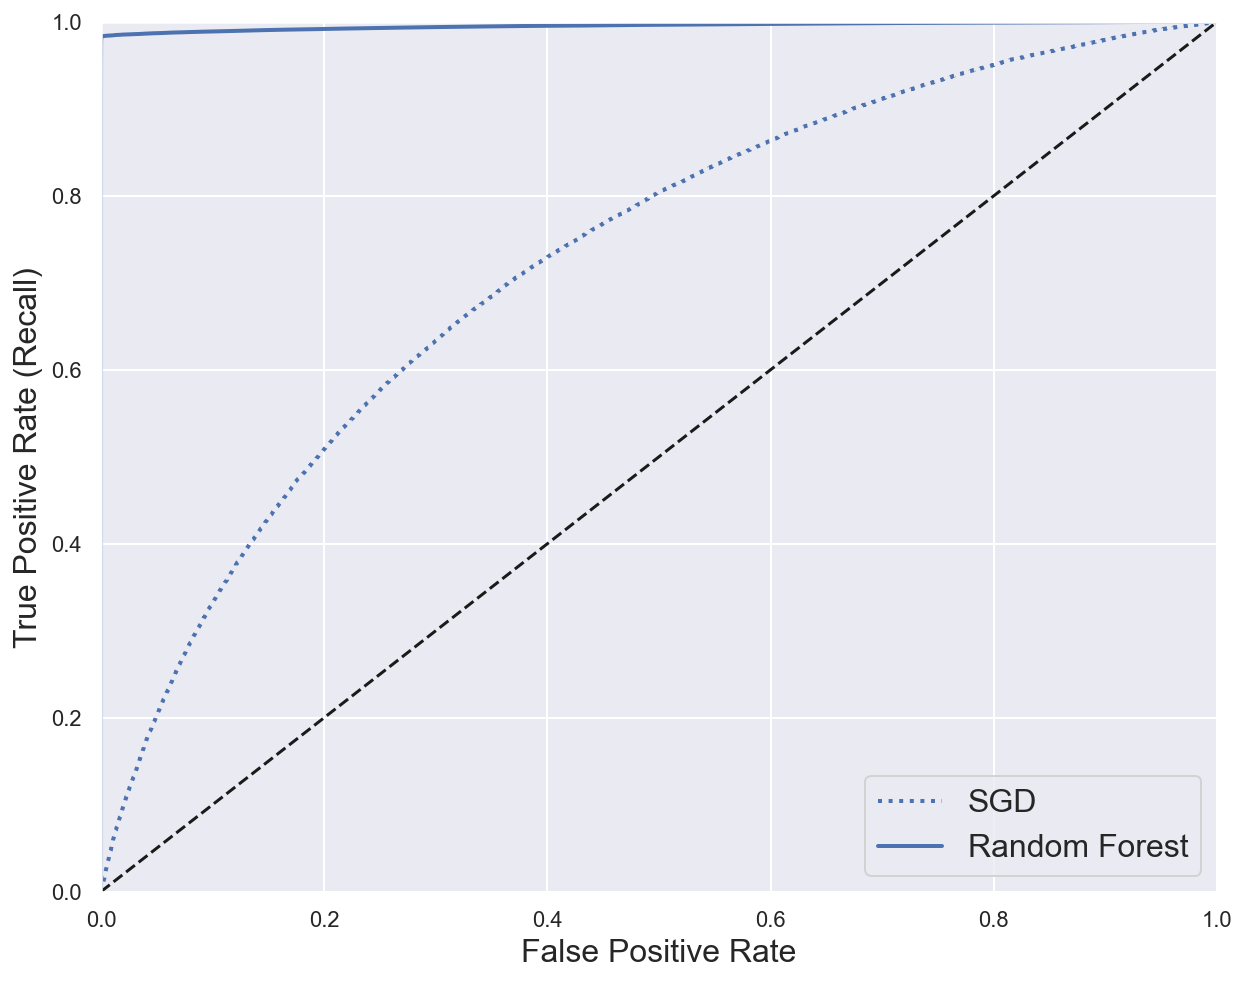

In [71]:
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.savefig('roc_curve_comparison_plot.png')
plt.show();

### AdaBoost

In [90]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train_rs, y_train_rs)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

In [91]:
ada_clf.predict_proba(X_test_lr)

array([[0.50052751, 0.49947249],
       [0.50429542, 0.49570458],
       [0.5001226 , 0.4998774 ],
       ...,
       [0.5045692 , 0.4954308 ],
       [0.50327424, 0.49672576],
       [0.50333188, 0.49666812]])

In [92]:
ada_clf.predict(X_test_lr)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### XGBoost

In [93]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, 
                              eval_metric="auc", max_depth=4,learning_rate=0.277, gamma=0.382)
xgb_model.fit(X_train_rs, y_train_rs)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0.382, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.277, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [94]:
print(roc_auc_score(y_train_rs, xgb_model.predict_proba(X_train_rs)[:,1]))

0.8083586709275555


In [95]:
print(f1_score(y_train_rs, xgb_model.predict(X_train_rs)))

0.46467059947928685
